# Analysing the pNEUMA dataset
Data from: https://open-traffic.epfl.ch/

***********************************************************************************************************
## References

Emmanouil Barmpounakis, Nikolas Geroliminis,
On the new era of urban traffic monitoring with massive drone data: The pNEUMA large-scale field experiment,
Transportation Research Part C: Emerging Technologies,
Volume 111,
2020,
Pages 50-71,
ISSN 0968-090X,
https://doi.org/10.1016/j.trc.2019.11.023.

Paul Newson and John Krumm. 2009. Hidden Markov map matching through noise and sparseness. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (GIS '09). Association for Computing Machinery, New York, NY, USA, 336–343. DOI:https://doi.org/10.1145/1653771.1653818

Meert, Wannes, and Verbeke, Mathias. HMM with Non-Emitting States for Map Matching. 2018.

Graser, Anita. “MovingPandas: Efficient Structures for Movement Data in Python.” GI_Forum, vol. 1, 2019, pp. 54–68. DOI:https://doi.org/10.1553/giscience2019_01_s54.

Boeing, G. 2017. OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. Computers, Environment and Urban Systems 65, 126-139. DOI:https://doi.org/10.1016/j.compenvurbsys.2017.05.004

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

SOMPY: A Python Library for Self Organizing Map (SOM)
V Moosavi, S Packmann, I Vallés
https://github.com/sevamoo/SOMPY
***********************************************************************************************************

In [1]:
import os
import csv
import glob
import math
import pickle
import traceback
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import numpy as np
import osmnx as ox
import datetime as dt
import contextily as ctx
import geopandas as gpd
import movingpandas as mpd
import sompylib.sompy as SOM

In [4]:
from geopy import distance
from datetime import timedelta
from geopandas import GeoDataFrame
from ipywidgets import IntSlider, interact 
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:
#from pydmd import DMD

*******************************************

# Browse data

In [7]:
files = []
root = os.getcwd()
path = './data/pNEUMA/'
os.chdir(path)
for file in glob.glob("*.csv"):
    files.append(file)
os.chdir(root)
find = 1
urlpath = f'{path}{files[find]}'
print(urlpath)

./data/pNEUMA/20181024_d8_0930_1000.csv


# Load data

In [8]:
def read_csv(path):
    metadata_cols = [
        'track_id',
        'type',
        'traveled_d',
        'avg_speed',
    ]
    data_cols = [
        'lat',
        'lon',
        'speed',
        'lat_acc',
        'lon_acc',
        'time',
        'track_id',
    ]

    metadata_colsize = len(metadata_cols)
    data_colsize = len(data_cols) - 1

    metadata_rows = list()
    data_rows = list()

    with open(path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        next(csv_reader)
        metadata = dict()
        for row in csv_reader:
            row = [item.strip() for item in row]
            track_id = int(row[0])
            metadata_rows.append(row[:metadata_colsize])

            data_traj = [
                float(item) for item in row[metadata_colsize:] if len(item) > 0
            ]
            for i in range(0, len(data_traj), data_colsize):
                data_row = data_traj[i:i + data_colsize] + [track_id]
                data_rows.append(data_row)

    data = pd.DataFrame(data_rows, columns=data_cols)
    metadata = pd.DataFrame(metadata_rows, columns=metadata_cols)
    metadata = metadata.set_index('track_id')
    metadata.index = metadata.index.astype(int)
    return metadata, data

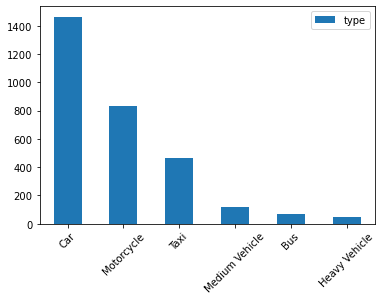

In [9]:
metadata, data = read_csv(urlpath)
ax = metadata.type.value_counts(dropna=False).plot.bar(rot=45, legend=True)

# Extract geometries for visualization

In [11]:
%%time
# Initialize points in ETRS89 reference system.
geometries = gpd.GeoDataFrame(data[['lat', 'lon', 'speed']],
                              geometry=gpd.points_from_xy(
                                  data.lon,
                                  data.lat,
                                  crs={'init': 'epsg:4326'}))
geometries.crs

CPU times: user 2min 32s, sys: 1.37 s, total: 2min 33s
Wall time: 2min 33s


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
%%time
# Convert to Pseudo-Mercator for cartography.
geometries = geometries.to_crs(epsg=3857)
geometries.crs

CPU times: user 3min 53s, sys: 800 ms, total: 3min 54s
Wall time: 3min 54s


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# Path for geometries.
geometries_dir = f"{path}geometries/"
if not os.path.exists(geometries_dir):
    os.makedirs(geometries_dir)
geometries_url = f'{geometries_dir}{files[find][:-3]}parquet.gzip'
geometries_url

'./data/pNEUMA/geometries/20181024_d8_0930_1000.parquet.gzip'

In [14]:
if os.path.exists(geometries_url):
    # Read geometries from file.
    geometries = gpd.read_parquet(geometries_url)    
else:
    # Write geometries to file.
    geometries.to_parquet(geometries_url, compression='gzip')

# Create trajectories

In [12]:
# Time entry.
year = 2018
month = 10
day = 24
hour = 9
minute = 30

In [13]:
# Merge metadata with data.
df = pd.merge(metadata[['type']],
              data,
              left_index=True,
              right_on='track_id')

In [20]:
# Create timestamps.
df['timestamp'] = df.apply(
    lambda x: dt.datetime(year, month, day, hour, minute) + timedelta(seconds=x.time),
    axis=1)
df = df.set_index('timestamp')

In [21]:
%%time
# Initialize points in ETRS89 reference system.
geolocations = gpd.GeoDataFrame(df,
                                geometry=gpd.points_from_xy(
                                    df.lon,
                                    df.lat,
                                    crs={'init': 'epsg:4326'}))
geolocations.crs

CPU times: user 2min 39s, sys: 1.14 s, total: 2min 40s
Wall time: 2min 40s


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
%%time
trajectories = []
for key, values in geolocations.groupby(['track_id']):
    try:
        trajectory = mpd.Trajectory(values, key)
        if trajectory.df.shape[0] > 1:
            trajectories.append(trajectory)
    except:
        pass

print("Finished creating {} trajectories".format(len(trajectories)))

Finished creating 2738 trajectories
CPU times: user 4.55 s, sys: 268 ms, total: 4.81 s
Wall time: 4.81 s


In [23]:
%%time
traj_collection = mpd.TrajectoryCollection(trajectories[:])
print(traj_collection)

TrajectoryCollection with 2738 trajectories
CPU times: user 7min 35s, sys: 20.2 ms, total: 7min 35s
Wall time: 7min 35s


In [34]:
# Path for unmatched trajectories.
trajectories_dir = f"{path}trajectories/"
if not os.path.exists(trajectories_dir):
    os.makedirs(trajectories_dir)
trajectories_url = f"{trajectories_dir}{files[find][:-4]}.pickle"
trajectories_url

'./data/pNEUMA/trajectories/20181024_d8_0930_1000.pickle'

In [15]:
if os.path.exists(trajectories_url):
    # Import trajectory collection.
    with open(trajectories_url, "rb") as f:
        unpickler = pickle.Unpickler(f)
        traj_collection = unpickler.load()    
else:
    # Export trajectory collection .
    with open(trajectories_url, 'wb') as f:
        pickle.dump(traj_collection, f)

# Vehicle movement visualization

In [16]:
def get_locations_at_timestamps(col, t):
    pos = []
    for traj in col.trajectories:
        if t >= traj.get_start_time() and t <= traj.get_end_time():
            pos.append({
                'geometry': traj.get_position_at(t),
                'id': str(traj.id),
                'type': traj.df['type'].values[0]
            })
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

In [17]:
# Extract x, y and c from geopandas.
latitude = geometries.geometry.y
longitude = geometries.geometry.x
c = geometries.speed

In [18]:
# Specify maptiles source.
basemap = ctx.providers.CartoDB.DarkMatter

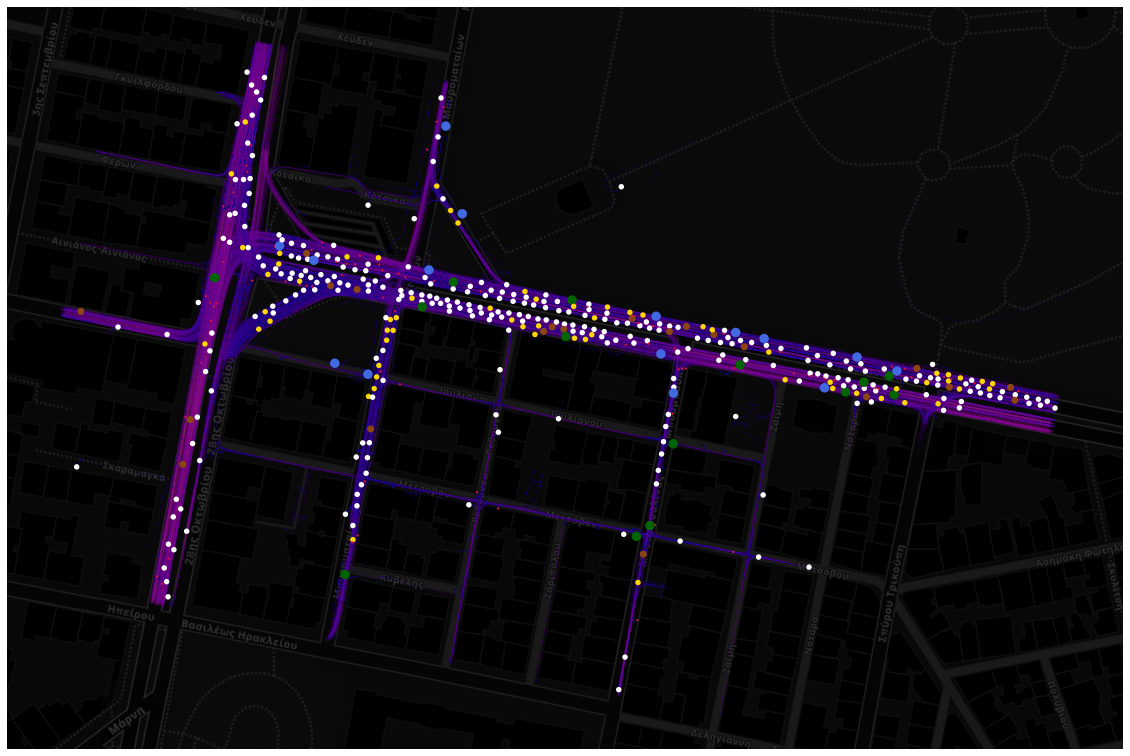

In [19]:
#@interact(i=(traj_collection.get_min('time'), traj_collection.get_max('time'), 0.5))
def plot(i=10):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(longitude, latitude, c=c, s=0.05, ec=None, cmap='plasma')

    t = dt.datetime(year, month, day, hour, minute) + timedelta(seconds=i)
    points = get_locations_at_timestamps(traj_collection, t)
    points = points.to_crs(epsg=3857)
    sizes = {
        'Car': 30,
        'Taxi': 30,
        'Bus': 90,
        'Motorcycle': 5,
        'Medium Vehicle': 50,
        'Heavy Vehicle': 90
    }
    colors = {
        'Car': 'white',
        'Taxi': 'gold',
        'Bus': 'royalblue',
        'Motorcycle': 'crimson',
        'Medium Vehicle': 'saddlebrown',
        'Heavy Vehicle': 'darkgreen'
    }
    points['sizes'] = points['type'].map(sizes)
    points['colors'] = points['type'].map(colors)
    lat_points = points.geometry.y
    lon_points = points.geometry.x
    sizes = points['sizes']
    colors = points['colors']
    ax.scatter(lon_points, lat_points, s=sizes, ec=None, c=colors)
    ax.set_axis_off()
    ctx.add_basemap(ax, attribution=False, source=basemap, zoom=18)
    #fig.savefig('alexandras.png', format='png', dpi=300)
plot()

********************************************

# Mapmatching

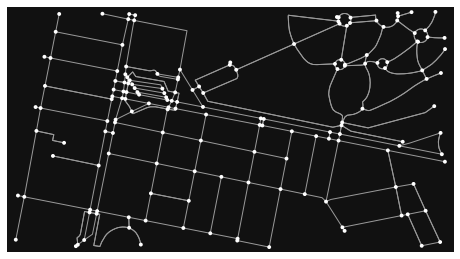

In [25]:
G = ox.graph_from_bbox(traj_collection.get_max('lat')+.0002,
                       traj_collection.get_min('lat')-.0001,
                       traj_collection.get_max('lon')+.0012,
                       traj_collection.get_min('lon')-.001,
                       simplify=True,
                       retain_all=False,
                       truncate_by_edge=False,
                       clean_periphery = False)
ax = ox.plot_graph(G)

In [26]:
def make_map(nodes, edges):
    map_con = InMemMap("myosm",
                       use_latlon=True,
                       use_rtree=True,
                       index_edges=True)
    
    for nid, row in nodes[['y', 'x']].iterrows():
        map_con.add_node(nid, (row['y'], row['x']))
    for nid, row in edges.reset_index()[['u', 'v']].iterrows():
        map_con.add_edge(row['u'], row['v'])

    return map_con

In [27]:
# Get nodes and edges from graph G
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [30]:
#****************************************************************
# Experiment setup and calibration
#****************************************************************
# Get nodes and edges from graph G
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
inbound = edges[(edges.name == 'Αλεξάνδρας')].take(
    [5, 7, 8, 9, 10, 11, 12, 13, 14, 17, 20, 22, 25])
inbound_end = inbound.take([-1]).reset_index()
inbound_start = inbound.take([-4]).reset_index()
inbound.reset_index(inplace=True)
outbound = edges[(edges.name == 'Αλεξάνδρας')].take(
    [0, 1, 2, 3, 4, 6, 15, 16, 18, 19, 21, 23, 24, 26])
outbound_start = outbound.take([-2]).reset_index()
outbound_end = outbound.take([-6]).reset_index()
outbound.reset_index(inplace=True)

# Origin point of inbound
inbound_origin = nodes.loc[inbound_start.u.values[0]].geometry
inbound_origin = (inbound_origin.y, inbound_origin.x)
# Destination point of inbound
inbound_destination = nodes.loc[inbound_end.v.values[0]].geometry
inbound_destination = (inbound_destination.y, inbound_destination.x)
# inbound geodesic distance
inbound_distance = distance.GeodesicDistance(inbound_origin, inbound_destination).m
print(f'Inbound Geodesic: {inbound_distance}')
# inbound ground truth distance
inbound_Distance = inbound['length'].sum()
print(f'Inbound True: {inbound_Distance}\n')
# inbound error factor
inbound_error = inbound_Distance / inbound_distance

# Origin point of outbound
outbound_origin = nodes.loc[outbound_start.u.values[0]].geometry
outbound_origin = (outbound_origin.y, outbound_origin.x)
# Destination point of outbound
outbound_destination = nodes.loc[outbound_end.v.values[0]].geometry
outbound_destination = (outbound_destination.y, outbound_destination.x)
# outbound geodesic distance
outbound_distance = distance.GeodesicDistance(outbound_origin, outbound_destination).m
print(f'Outbound Geodesic: {outbound_distance}')
# outbound ground truth distance
outbound_Distance = outbound['length'].sum()
print(f'Outbound True: {outbound_Distance}')
# outbound error factor
outbound_error = outbound_Distance / outbound_distance

Inbound Geodesic: 568.8938791629043
Inbound True: 567.626

Outbound Geodesic: 576.4286953320936
Outbound True: 575.1429999999999


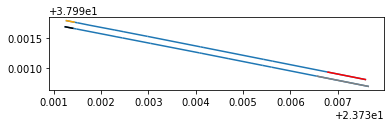

In [31]:
ax = edges[(edges.name == 'Αλεξάνδρας')].plot()
ax = inbound_start.plot(ax=ax, color='red')
ax = inbound_end.plot(ax=ax, color='orange')
ax = outbound_start.plot(ax=ax, color='black')
ax = outbound_end.plot(ax=ax, color='grey')

In [ ]:
%%time
#****************************************************************
# Main mapmatching routine
#****************************************************************
# Make connectivity map
map_con = make_map(nodes, edges)
# List to store trips of interest
trips = []
# Loop through all original trajectories
for trajectory in tqdm(traj_collection.trajectories[:]):
    try:
        trip = trajectory.df.copy(deep=True).reset_index()
        route = [tuple(x) for x in trip[['lat', 'lon']].to_numpy()]
        # Run matcher
        matcher = DistanceMatcher(map_con,
                                  max_dist=300,
                                  min_prob_norm=0.0001,
                                  obs_noise=20,
                                  max_lattice_width=8,
                                  avoid_goingback=True,
                                  non_emitting_states=False)
        states, _ = matcher.match(route, tqdm=None)
        states_df = pd.DataFrame(states, columns=['u', 'v'])
        # Extract projected coordinates
        coords_list = []
        match = matcher.lattice_best
        for m in match:
            lat, lon = m.edge_m.pi[:2]
            coords_list.append((lat, lon))
        coords_df = pd.DataFrame(coords_list)
        projection = gpd.GeoDataFrame(coords_df,
                                      geometry=gpd.points_from_xy(
                                          coords_df[1],
                                          coords_df[0],
                                          crs={'init': 'epsg:4326'}))
        trip['projection'] = projection['geometry'].values
        # Match trip with the respective street
        trip['u'] = states_df.u.values
        trip['v'] = states_df.v.values
        trip = pd.merge(trip,
                        edges.reset_index(),
                        how='left',
                        left_on=['u', 'v'],
                        right_on=['u', 'v'])
        # Check if arterial is part of the trip
        trip.rename({
            'geometry_x': 'geometry',
            'geometry_y': 'linestring'
        },
                    axis=1,
                    inplace=True)  
        
        outbound_mask = trip.linestring.astype(str).isin(outbound.geometry.astype(str))
        inbound_mask = trip.linestring.astype(str).isin(inbound.geometry.astype(str))
        
        if np.any(outbound_mask) or np.any(inbound_mask):
            if np.any(outbound_mask):
                trip = gpd.GeoDataFrame(trip[outbound_mask].reset_index(drop=True))
                # Measure calibrated distance from outbound origin
                distances = []
                for point in trip.projection.values:
                    coords = (point.y, point.x)
                    d = distance.GeodesicDistance(outbound_origin, coords).m
                    distances.append(d * outbound_error)
                trip['distances'] = distances
                trip['tag'] = 'upstream' #'outbound'
                trips.append(trip)
            if np.any(inbound_mask):
                trip = gpd.GeoDataFrame(trip[inbound_mask].reset_index(drop=True))
                # Measure calibrated distance from inbound origin
                distances = []
                for point in trip.projection.values:
                    coords = (point.y, point.x)
                    d = distance.GeodesicDistance(inbound_origin, coords).m
                    distances.append(d * inbound_error)
                trip['distances'] = distances
                trip['tag'] = 'downstream' #'inbound'
                trips.append(trip)
        else:
            continue
    except Exception as ex:
        print(ex.args[0])
        continue      

***********************************

# Serialize valid trajectories

In [ ]:
valid_trajectories = []
for trip in trips:
    if len(trip) <= 2:
        continue
    trajectory = mpd.Trajectory(trip.set_index('timestamp'),
                                traj_id='track_id')
    valid_trajectories.append(trajectory)

In [61]:
%%time
valid_traj_collection = mpd.TrajectoryCollection(valid_trajectories[:])
print(valid_traj_collection)

TrajectoryCollection with 1847 trajectories
CPU times: user 4min 14s, sys: 42.3 ms, total: 4min 14s
Wall time: 4min 14s


In [36]:
# Path for matched trajectories.
collection_dir = f"{path}collections/"
if not os.path.exists(collection_dir):
    os.makedirs(collection_dir)
collection_url = f"{collection_dir}{files[find][:-4]}.pickle"
collection_url

'./data/pNEUMA/collections/20181024_d8_0930_1000.pickle'

In [37]:
%%time
if os.path.exists(collection_url):
    # Import trajectory collection .
    with open(collection_file, 'rb') as f:
        unpickler = pickle.Unpickler(f)
        valid_traj_collection = unpickler.load() 
else:    
    # Export trajectory collection.
    with open(collection_file, 'wb') as f:
        pickle.dump(valid_traj_collection, f, protocol=-1)

CPU times: user 53.2 s, sys: 2.46 s, total: 55.7 s
Wall time: 57.3 s


# Extract most important features

In [38]:
dfs = []
for trajectory in valid_traj_collection.trajectories:
    df = trajectory.df
    df['lat'] = df.geometry.y
    df['lon'] = df.geometry.x
    dfs.append(df[[
        'track_id', 'lat', 'lon', 'time', 'speed', 'type', 'distances', 'tag'
    ]].reset_index(drop=True))
dfs = pd.concat(dfs[:]).reset_index(drop=True)

In [72]:
# Path for dataframes
dataframe_dir = f"{path}dataframes/"
if not os.path.exists(dataframe_dir):
    os.makedirs(dataframe_dir)
dataframe_url = f"{dataframe_dir}{files[find][:-4]}.parquet.gzip"
dataframe_url

'./data/pNEUMA/dataframes/20181024_d8_0900_0930.parquet.gzip'

In [73]:
# Write dataframes to file.
dfs.to_parquet(dataframe_url, compression='gzip')

***********************************************

# Principal Component Analysis (PCA)

In [8]:
dataframe_urls = []
root = os.getcwd()
dataframe_dir = f"{path}dataframes/"
os.chdir(dataframe_dir)
for filename in glob.glob("*.gzip"):
    dataframe_url = f'{dataframe_dir}{filename}'
    print(dataframe_url)
    dataframe_urls.append(dataframe_url)
os.chdir(root)

./data/pNEUMA/dataframes/20181024_d8_1030_1100.parquet.gzip
./data/pNEUMA/dataframes/20181024_d8_0900_0930.parquet.gzip
./data/pNEUMA/dataframes/20181024_d8_1000_1030.parquet.gzip
./data/pNEUMA/dataframes/20181024_d8_0930_1000.parquet.gzip


In [9]:
# Aggregate time slots.
dfs = []
for url in dataframe_urls:
    df = pd.read_parquet(url)
    df['url'] = url.split('/')[-1].split('.')[0]
    dfs.append(df)
df = pd.concat(dfs)
del dfs

In [10]:
# Perform PCA on latitude and longitude.
pca_cols = [
    'lat',
    'lon',
]
X = df[pca_cols].reset_index(drop=True)
pca = PCA(n_components=len(pca_cols), random_state=0)
X = pca.fit_transform(X)
X = StandardScaler().fit_transform(X)

In [11]:
df['PC1'] = X[:, 0]
df['PC2'] = X[:, 1]

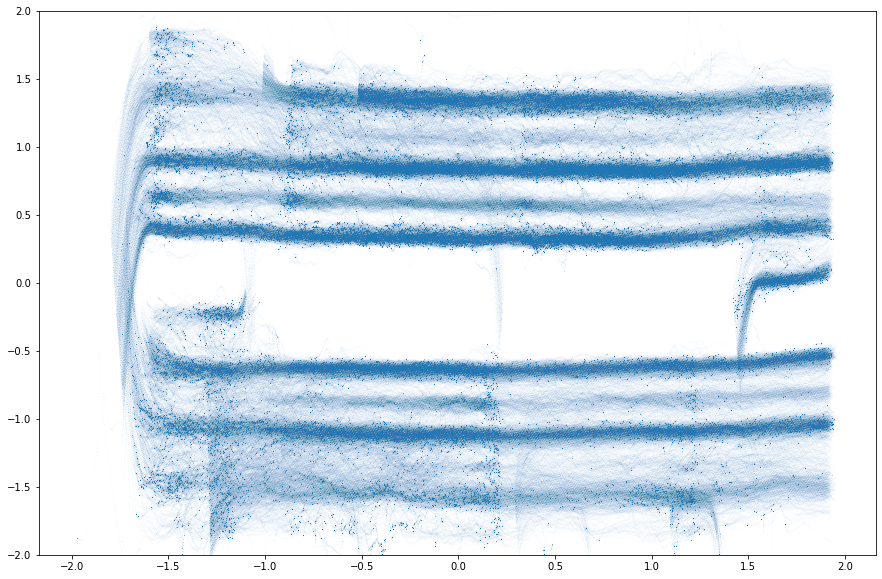

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-2, 2])
ax = plt.scatter(-X[:, 0], -X[:, 1], s=2e-5)

In [13]:
# Standardize principal components of inbound traffic.
df = df[(df.tag == 'downstream')
        & (df.url == '20181024_d8_0930_1000')].reset_index(drop=True)
X = StandardScaler().fit_transform(df[['PC1','PC2']].values)

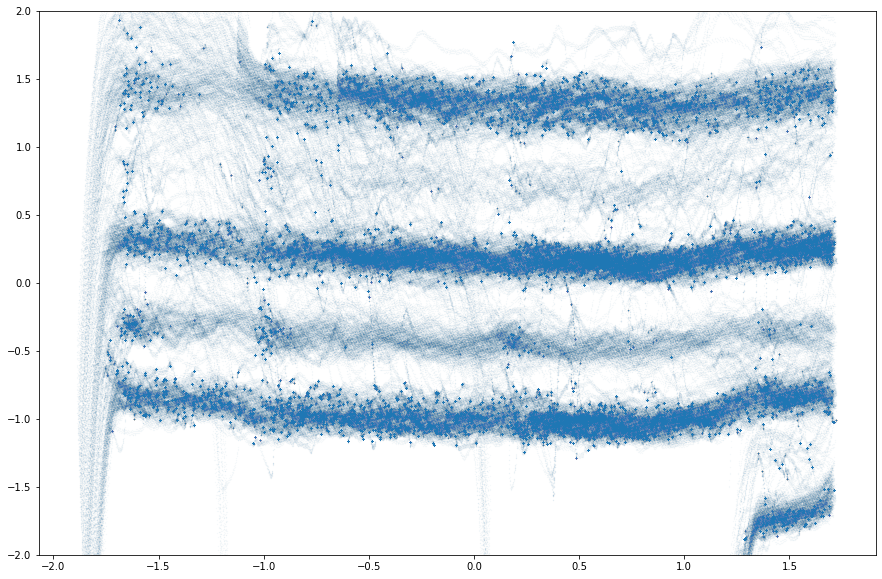

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-2, 2])
ax = plt.scatter(-X[:, 0], -X[:, 1], s=2e-4)

 **********************

# Pre-indexing with Self Organizing Map (SOM)

In [15]:
# Randomly sample coordinates
size = int(1e5)
training = X[np.random.choice(len(X), size, replace=False)]
som_path = f'{path}som2.gz'
som_path

'./data/pNEUMA/som2.gz'

In [16]:
if os.path.exists(som_path):
    # Load SOM from disk
    som2 = SOM.load(filename=som_path)
else:
    # Train SOM
    msz11 = 166
    msz10 = 166

    som2 = SOM.SOM('',
                   training,
                   mapsize=[msz10, msz11],
                   norm_method='var',
                   initmethod='pca')
    som2.init_map()
    som2.train(n_job=8, shared_memory='yes', verbose='final')
    # Save SOM to disk
    SOM.dump(som2, filename=som_path)

Total time elapsed: 604.190000 secodns
final quantization error: 0.006402


In [17]:
# Calculate best matching units (bmus).
bmus = som2.project_data(X)
df['bmu'] = bmus

In [18]:
# Get bmu coordinates.
codebook2 = som2.codebook[:]
codebook2_n = SOM.denormalize_by(som2.data_raw,
                                 codebook2,
                                 n_method="var")

In [29]:
# Clear memory.
import gc
som2 = None
del som2
gc.collect()

6521

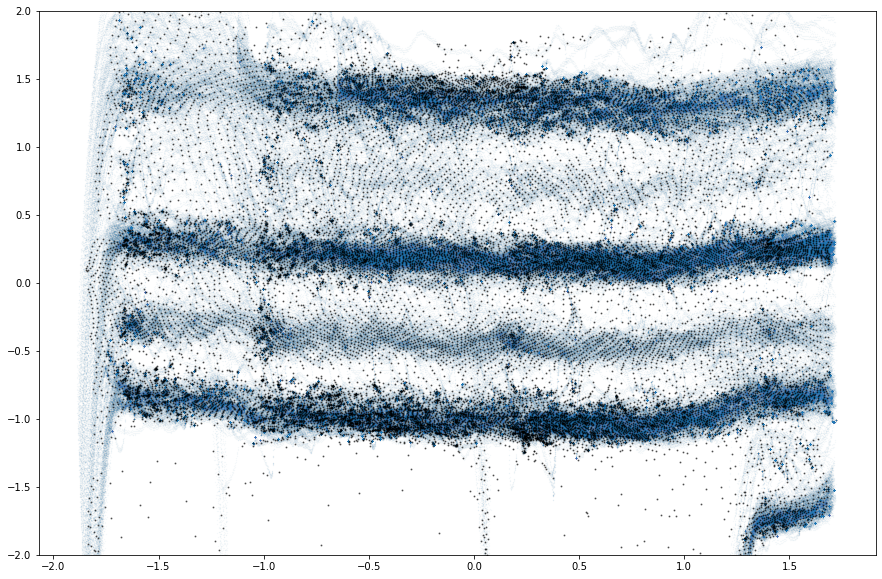

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-2, 2])
plt.scatter(-X[:, 0], -X[:, 1], s=2e-4)
ax = plt.scatter(-codebook2_n[:, 0],
                 -codebook2_n[:, 1],
                 c='black',
                 s=1,
                 alpha=.5)

# Clustering with DBSCAN

In [20]:
active = list(set(np.unique(bmus)))
len(active)/len(codebook2_n)

0.9882784148642764

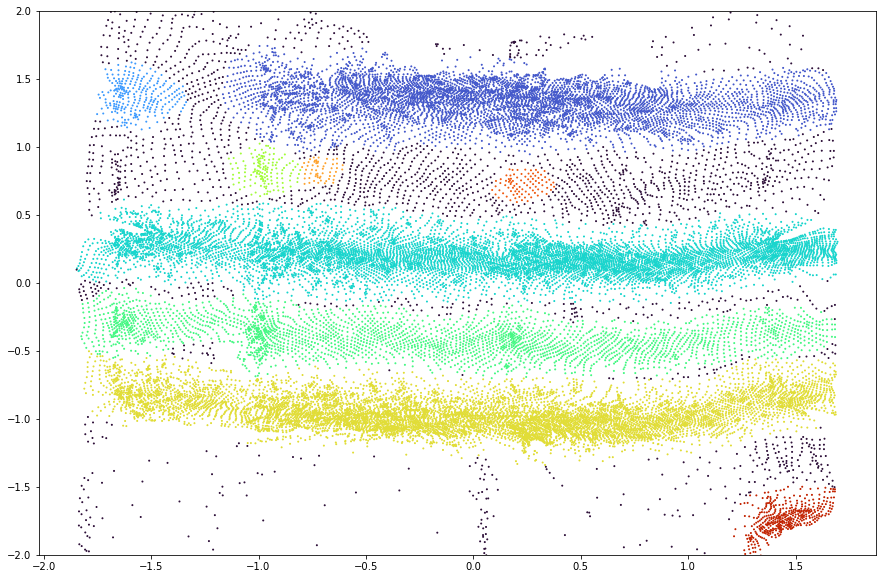

In [21]:
dbscan = DBSCAN(eps=0.1, min_samples=50, algorithm='auto', n_jobs=-1)
clusters = dbscan.fit_predict(codebook2_n[:, [0, 1]])
fig, ax = plt.subplots(figsize=(15, 10))
plt.ylim([-2, 2])
ax = plt.scatter(-codebook2_n[:, 0],
                 -codebook2_n[:, 1],
                 s=1,
                 alpha=1,
                 c=clusters[:],
                 cmap='turbo')

 ***************************************************************

# Lane assignment

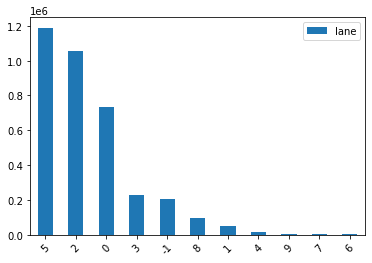

In [22]:
result = pd.merge(df,
                  pd.DataFrame(clusters),
                  how='left',
                  left_on=['bmu'],
                  right_index=True)
result.rename({0: 'lane'}, axis=1, inplace=True)
ax = result.lane.value_counts(dropna=False).plot.bar(rot=45, legend=True)

************************************************

# Time-space diagram (per lane)

In [23]:
# List of lanes
lanes = []
for i in [0, 2, 3, 5]:
    lane = result[(result.lane == i)]
    lane.reset_index(drop=True, inplace=True)
    lanes.append(lane)

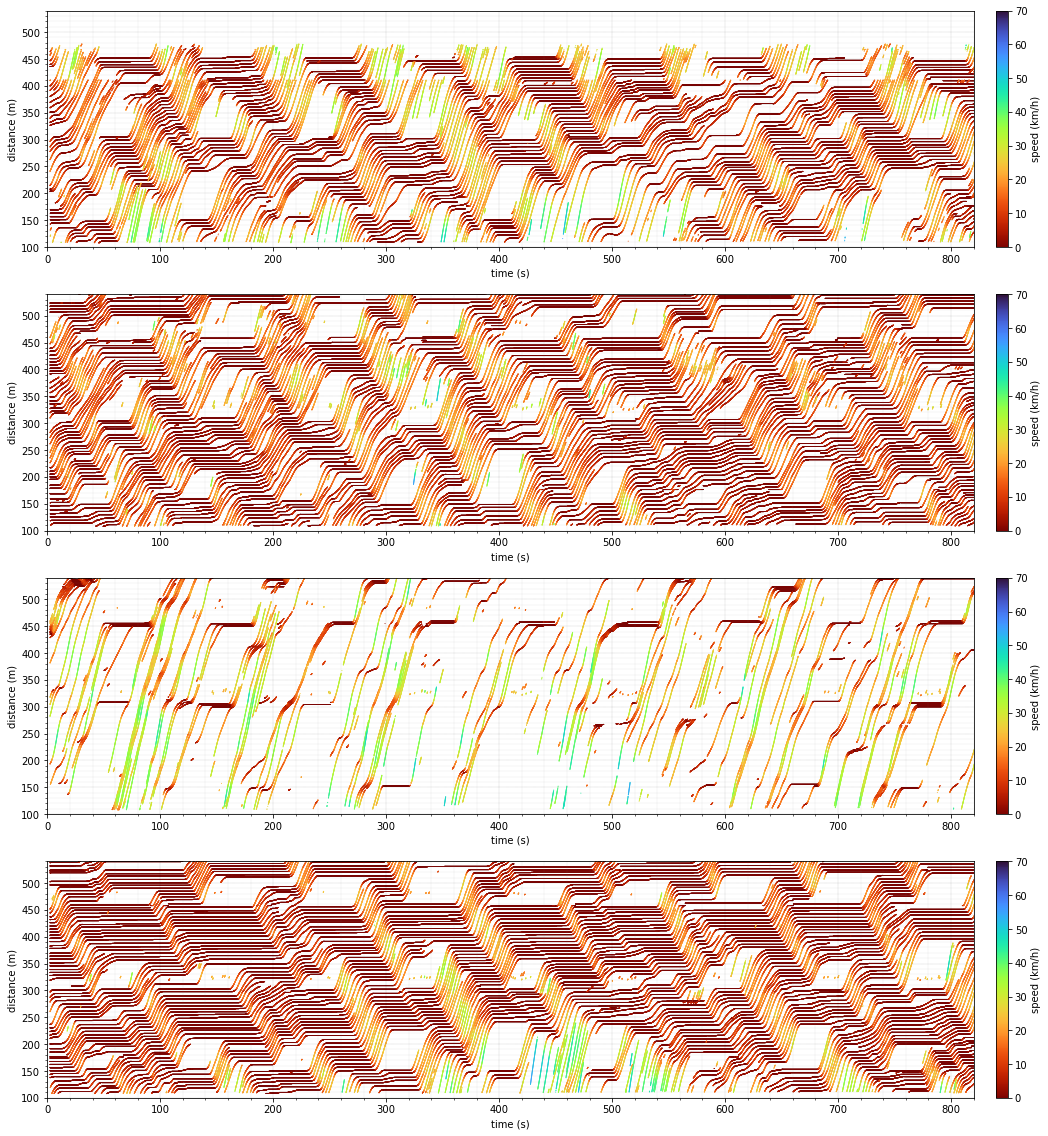

In [24]:
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

for i, lane in enumerate(lanes):
    axes[i].set_xlim([0, 820])
    axes[i].set_ylim([100, 540])
    axes[i].minorticks_on()
    axes[i].grid(which='minor', linestyle='--', linewidth=0.1, color='grey')
    axes[i].grid(which='major', linestyle='--', linewidth=0.1, color='black')

    times = lane.time.values
    speed = lane.speed.values
    distances = lane.distances.values
    pcm = axes[i].scatter(times,
                          distances,
                          c=speed,
                          s=1,
                          ec=None,
                          cmap='turbo_r',
                          alpha=1,
                          vmin=0,
                          vmax=70,
                          antialiased=True)
    axes[i].set_xlabel('time (s)')
    axes[i].set_ylabel('distance (m)')
    fig.colorbar(pcm, ax=axes[i], pad=0.02, label='speed (km/h)')
#fig.savefig('speed.png', format='png', dpi=200)